In [1]:
# ====================================================================
# NOTEBOOK: train_model_jantung_NON_PCA.ipynb
# ====================================================================

# ### 🚀 1. Setup & Memuat Data ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")
df = pd.read_csv('data/df_cleaned_jantung.csv')
print("✅ Dataset bersih berhasil dimuat.")

✅ Dataset bersih berhasil dimuat.


In [2]:
# ### 🛠️ 2. Pra-pemrosesan & Pipeline ###
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)
print("✅ Data telah dibagi dan pipeline preprocessing siap.")

✅ Data telah dibagi dan pipeline preprocessing siap.


===== Optimasi Model: Logistic Regression =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__C': 0.1}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        40
           1       0.84      0.77      0.81        35

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.82        75
weighted avg       0.83      0.83      0.83        75



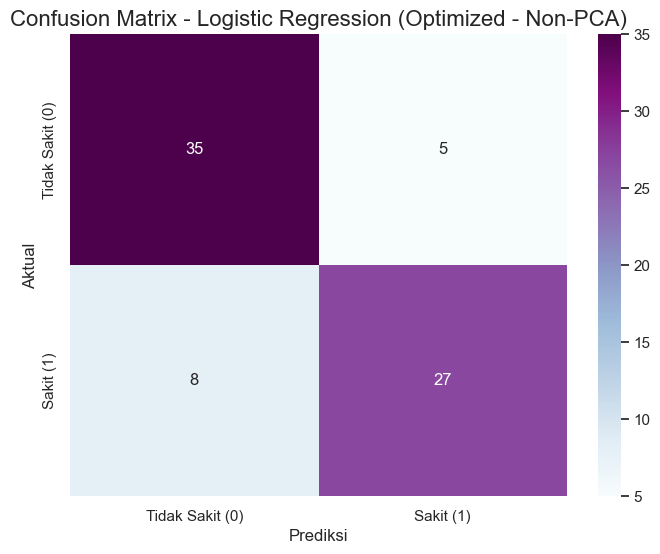

✅ Model hasil optimasi 'Logistic Regression' disimpan di: models/jantung/optimize_non_pca\logistic_regression_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: Random Forest =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.83      0.71      0.77        35

    accuracy                           0.80        75
   macro avg       0.81      0.79      0.80        75
weighted avg       0.80      0.80      0.80        75



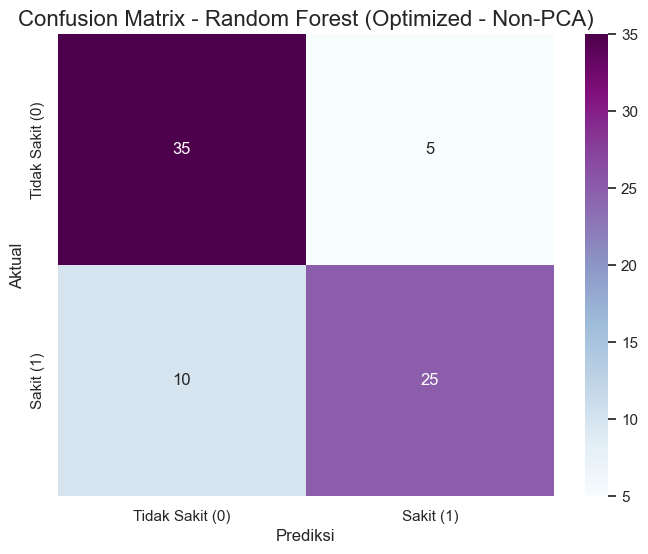

✅ Model hasil optimasi 'Random Forest' disimpan di: models/jantung/optimize_non_pca\random_forest_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: SVC =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__C': 1, 'classifier__gamma': 'scale'}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.87      0.77      0.82        35

    accuracy                           0.84        75
   macro avg       0.84      0.84      0.84        75
weighted avg       0.84      0.84      0.84        75



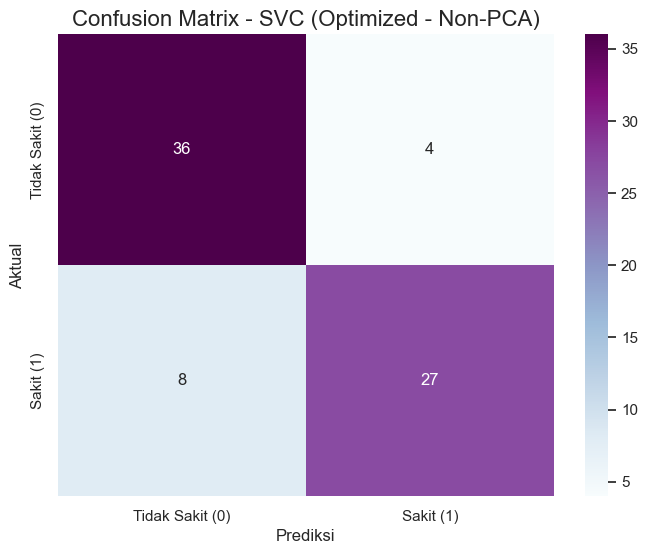

✅ Model hasil optimasi 'SVC' disimpan di: models/jantung/optimize_non_pca\svc_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: XGBoost =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        40
           1       0.83      0.69      0.75        35

    accuracy                           0.79        75
   macro avg       0.79      0.78      0.78        75
weighted avg       0.79      0.79      0.78        75



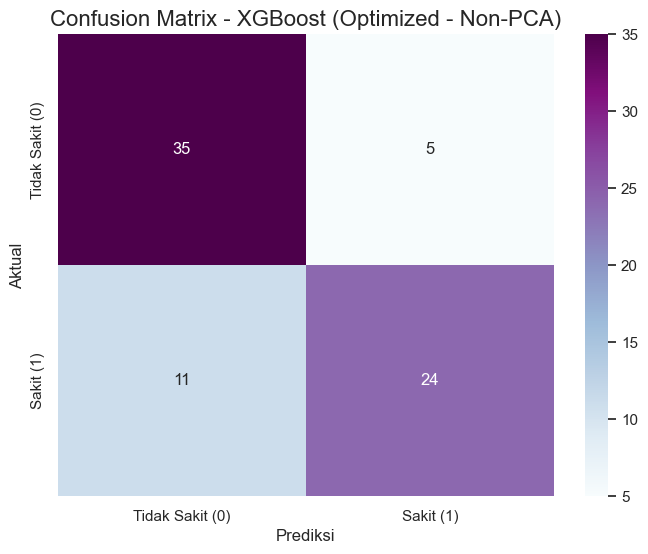

✅ Model hasil optimasi 'XGBoost' disimpan di: models/jantung/optimize_non_pca\xgboost_optimized.pkl
------------------------------------------------------------


In [3]:
# ### 🏋️‍♂️ 3. Pelatihan & Optimasi Model ###

def plot_confusion_matrix(y_true, y_pred, model_name=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', 
                xticklabels=['Tidak Sakit (0)', 'Sakit (1)'], 
                yticklabels=['Tidak Sakit (0)', 'Sakit (1)'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.ylabel('Aktual', fontsize=12)
    plt.xlabel('Prediksi', fontsize=12)
    plt.show()

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

param_grids = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'Random Forest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]},
    'SVC': {'classifier__C': [1, 10], 'classifier__gamma': ['scale', 'auto']},
    'XGBoost': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1]}
}

output_dir_optimized = 'models/jantung/optimize_non_pca'
os.makedirs(output_dir_optimized, exist_ok=True)
best_models_non_pca = {}

for name, model in models.items():
    print(f"===== Optimasi Model: {name} =====\n")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Parameter terbaik: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models_non_pca[name] = best_model
    
    y_pred_optimized = best_model.predict(X_test)
    print("\n--- Laporan Klasifikasi (Optimized) ---")
    print(classification_report(y_test, y_pred_optimized))
    plot_confusion_matrix(y_test, y_pred_optimized, f"{name} (Optimized - Non-PCA)")
    
    model_path = os.path.join(output_dir_optimized, f'{name.lower().replace(" ", "_")}_optimized.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"✅ Model hasil optimasi '{name}' disimpan di: {model_path}\n{'-'*60}")

### 💾 Menyimpan Data Uji untuk Evaluasi Terpisah

Kita simpan `X_test` dan `y_test` ke dalam file CSV. File-file ini nantinya akan dimuat oleh notebook `evaluate_model` untuk melakukan perbandingan antar model secara adil pada data yang sama.

In [4]:
# Buat folder 'training' jika belum ada
os.makedirs('training', exist_ok=True)

# Simpan data tes ke file CSV
X_test.to_csv('training/X_test_non_pca.csv', index=False)
y_test.to_csv('training/y_test_non_pca.csv', index=False)

print("✅ Data uji (X_test_non_pca.csv dan y_test_non_pca.csv) berhasil disimpan.")

✅ Data uji (X_test_non_pca.csv dan y_test_non_pca.csv) berhasil disimpan.
